In [107]:
import numpy as np 
import pandas as pd 
# pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns



In [108]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')





## Loading the data 

In [109]:
df = pd.read_excel("text_classification_dataset.xlsx")
df = df.reindex(np.random.permutation(df.index))
df.head()

,text,type
46,RT @BoldBrigade: Congratulating our Captain Virat Kohli for winning the 2019 Spirit of Cricket Award at #ICCAwards!\n\n#PlayBold #ViratKohli…,sports
765,"RT @CNN: Comedian Dave Chappelle announced his endorsement of presidential candidate Andrew Yang, becoming the latest celebrity to throw hi…",politics
14,"RT @ians_india: #India skipper #ViratKohli is surprised to have won the #ICC Spirit of #Cricket Award for 2019 on Wednesday, as for many ye…",sports
574,"RT @mollyd522: Patsy Mink was rejected by every medical school she applied to bc she was a woman. So, she became a lawyer and got elected t…",medical
1122,"RT @FOXSportsAsia: “Talking with Roger we decided to give 250,000 Australian dollars to the fire relief together”\n\n@RafaelNadal made the re…",sports


## Exploratory Data Analysis

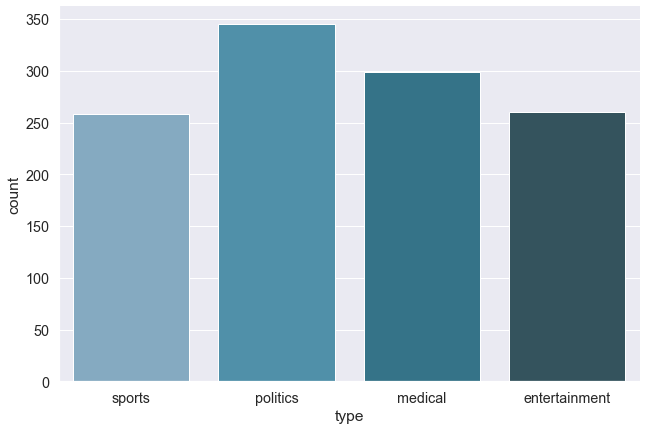

In [110]:
sns.factorplot(x = "type", data = df, kind = "count", size = 6, aspect = 1.5, palette = "PuBuGn_d")

## Lets check Input Variables

In [111]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
df_eda['type'] = df.type
df_eda

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,type
46,19,1,3,1,1,0,0,sports
765,20,1,0,2,0,0,0,politics
14,24,1,4,2,0,0,0,sports
574,27,1,0,1,0,0,0,medical
1122,22,2,0,1,0,0,0,sports
...,...,...,...,...,...,...,...,...
966,20,0,0,0,0,1,0,politics
502,18,1,0,2,0,0,0,medical
412,22,0,0,1,0,1,0,medical
580,24,0,0,0,0,0,0,medical


## Text Cleaning

In [112]:

class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [113]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
df["clean_text"] = sr_clean
df_clean = df[["clean_text","type"]]
df_clean

,clean_text,type
46,rt congratul captain virat kohli win spirit cricket award iccaward playbold viratkohli…,sports
765,rt comedian dave chappel announc endors presidenti candid andrew yang becom latest celebr throw hi…,politics
14,rt india skipper viratkohli surpris icc spirit cricket award wednesday mani ye…,sports
574,rt patsi mink reject everi medic school appli bc woman becam lawyer got elect t…,medical
1122,rt “talk roger decid give australian dollar fire relief together” made re…,sports
...,...,...
966,ukrain prosecutor offer inform relat biden exchang ambassador’ ouster newli releas materia…,politics
502,rt icymi former vice presid insi therapeut sentenc racket conspiraci defend first ex…,medical
412,job york unit state medic receptionist york medic clinic provid patient at…,medical
580,care peopl way much that’ gonna one hardest obstacl overcom go medic field,medical


In [114]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)


In [115]:
df_model = df_clean

df_model.columns.tolist()

['clean_text', 'type']

In [116]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [117]:
df_model.head()
    
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('type', axis=1), df_model.type, test_size=0.1, random_state=37)


In [118]:
def grid_vect(clf, parameters_clf, X_train, X_test,parameters_text=None, vect=None):

    features = FeatureUnion([('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    pipeline = Pipeline([('features',features),('clf',clf)])
    
    parameters = dict()
    
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [119]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [120]:
mnb = MultinomialNB()
logreg = LogisticRegression()

In [121]:
countvect = CountVectorizer()
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 165 out of 180 | elapsed:    5.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


done in 5.963s

Best CV score: 0.828
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.803


Classification Report Test Data
               precision    recall  f1-score   support

entertainment       0.77      0.87      0.82        23
      medical       0.85      0.78      0.81        36
     politics       0.75      0.73      0.74        37
       sports       0.86      0.90      0.88        21

     accuracy                           0.80       117
    macro avg       0.81      0.82      0.81       117
 weighted avg       0.80      0.80      0.80       117

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 345 out of 360 | elapsed:   12.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   13.1s finished


done in 13.438s

Best CV score: 0.815
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.803


Classification Report Test Data
               precision    recall  f1-score   support

entertainment       0.85      0.74      0.79        23
      medical       0.84      0.75      0.79        36
     politics       0.69      0.84      0.76        37
       sports       0.95      0.90      0.93        21

     accuracy                           0.80       117
    macro avg       0.83      0.81      0.82       117
 weighted avg       0.82      0.80      0.81       117



In [106]:
# from sklearn import svm

# svm = svm.SVC(kernel = 'linear', probability = True)


# parameter_svm = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']} 

# best_svm_countvect = grid_vect(svm, parameters_svm, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
 'kernel': ['rbf']}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: Invalid parameter kernel for estimator Pipeline(steps=[('features',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('pipe',
                                                 Pipeline(steps=[('cleantext',
                                                                  ColumnExtractor(cols='clean_text')),
                                                                 ('vect',
                                                                  CountVectorizer())]))])),
                ('clf', SVC(kernel='linear', probability=True))]). Check the list of available parameters with `estimator.get_params().keys()`.